<a href="https://colab.research.google.com/github/luisespriella9/Deep-Learning-Advanced-Computer-Vision/blob/master/VVG_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get Google Drive Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! ls 'drive/My Drive/fruits-360'

LICENSE  readme.md  Test  Training


In [3]:
! ls 'drive/My Drive/fruits-360/Training'

Banana	Raspberry  Strawberry


Get Data for Raspberry, Banana and Strawberry

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [0]:
train_path = 'drive/My Drive/fruits-360/Training'
test_path = 'drive/My Drive/fruits-360/Test'

In [0]:
# get number of files
image_files = glob(train_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

# get number of classes
folders = glob(train_path + '/*')

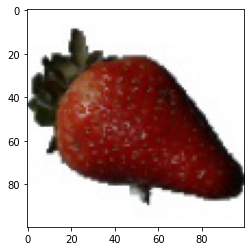

In [9]:
# look at an image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

VGG16 Layer

In [15]:
vgg = VGG16(input_shape=(100, 100, 3), weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [0]:
# our layers
flatten_layer_output = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(flatten_layer_output)

In [0]:
# create object model
model = Model(inputs=vgg.inputs, outputs=prediction)

# view structure of model
model.summary()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Image Data Generator

In [0]:
gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, preprocessing_function=preprocess_input)